C:\Users\anton\anaconda3\Lib\site-packages\dash\dash.py:550: UserWarning:

JupyterDash is deprecated, use Dash instead.
See https://dash.plotly.com/dash-in-jupyter for more details.



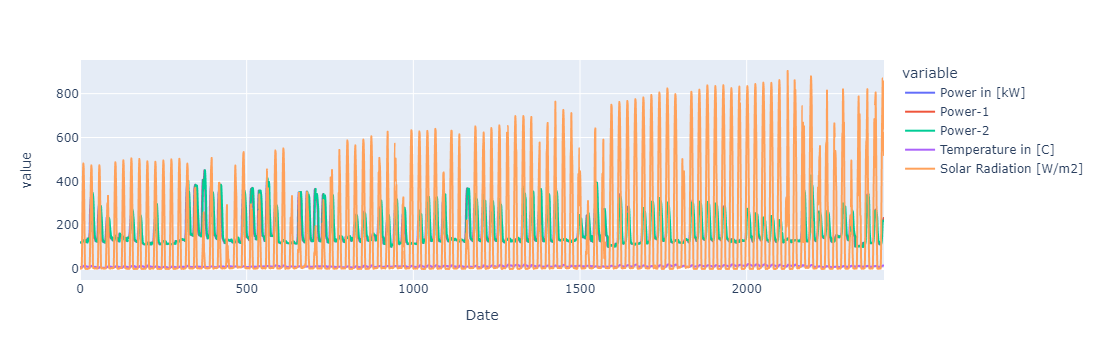

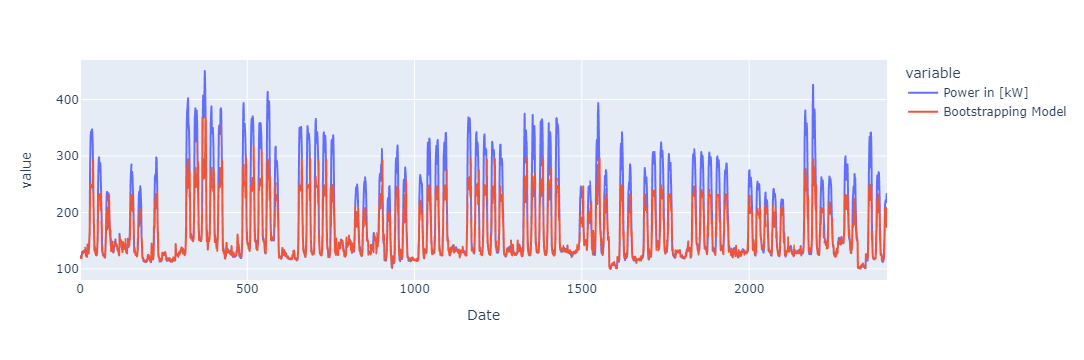

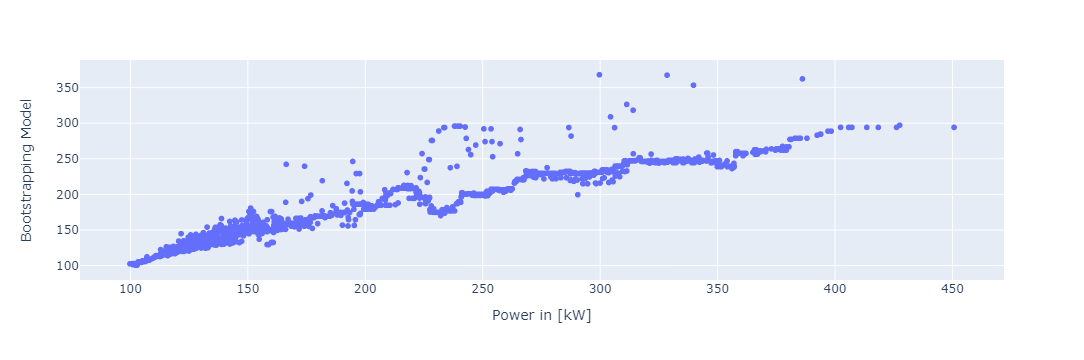

Dash app running on http://127.0.0.1:8050/


In [122]:
!pip install dash
!pip install jupyter_dash

import os
import dash
from dash import html
from dash import dcc
from jupyter_dash import JupyterDash
from dash.dependencies import Input, Output
import pandas as pd
import plotly.express as px
import plotly.io as pio
import pickle
from sklearn import  metrics
import numpy as np
import plotly.graph_objs as go



#define css style by entering link

external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']
app = JupyterDash(__name__, external_stylesheets=external_stylesheets)
server=app.server


 


#load data from my project 1

df_2019=pd.read_csv("df_new_2019.csv")



#df_2019['Date'] = pd.to_datetime (df_2019['Date'])
#df_2019 = df_2019.drop(['HR', 'windSpeed_m/s', 'windGust_m/s', 'pres_mbar', 'rain_mm/h','rain_day'], axis=1)
#df_2019.rename(columns = {'temp_C': 'Temperature in [C]','Central (kWh)': 'Power in [kW]', 'windSpeed_m/s': 'Wind Speed [m/s]','solarRad_W/m2': 'Solar Radiation [W/m2]'}, inplace = True)
#df_2019['Power-1']=df_2019['Power in [kW]'].shift(1) 
#df_2019['Power-2'] = df_2019['Power-1'].shift(1)
#df_2019=df_2019.dropna()
#df_2019=df_2019.iloc[:, [0,3,4,1,2]]




columns = df_2019.columns.tolist()
X2=df_2019.values

df_2019.reset_index(inplace=True)
df_2019.rename(columns={'index': 'Date'}, inplace=True)
fig1 = px.line(df_2019, x="Date", y=df_2019.columns[1:6])

     


fig1.show()


#Bootstrap Model

with open('BT_mod.pkl','rb') as file:
    BT_mod=pickle.load(file) 


  


Z=df_2019.values
Y=Z[:,0]
X2=Z[:,[1,2,3,4,5]]  # Selecting columns at indices 1 through 5


Y_BT = BT_mod.predict(X2)

#Evaluate errors

MAE_BT = metrics.mean_absolute_error(Y, Y_BT)
MBE_BT = np.mean(Y - Y_BT)
MSE_BT = metrics.mean_squared_error(Y, Y_BT)
RMSE_BT = np.sqrt(metrics.mean_squared_error(Y, Y_BT))
cvRMSE_BT = RMSE_BT / np.mean(Y)
NMBE_BT = MBE_BT / np.mean(Y)

# Create data frames with predictin results and error metrics 
d = {'Methods': ['Bootstrapping Model'], 'MAE': [MAE_BT],'MBE': [MBE_BT], 'MSE': [MSE_BT], 'RMSE': [RMSE_BT],'cvMSE': [cvRMSE_BT],'NMBE': [NMBE_BT]}
df_metrics = pd.DataFrame(data=d)
d={'Date':df_2019['Date'].values, 'Bootstrapping Model': Y_BT}
df_forecast=pd.DataFrame(data=d)

# merge real and forecast results and creates a figure with it
df_results=pd.merge(df_2019,df_forecast,on='Date')


fig2 = px.line(df_results, x='Date', y=[df_results.columns[1], 'Bootstrapping Model'])

fig6 = px.scatter(df_results, x=df_results.columns[1], y='Bootstrapping Model')


fig2.show()

fig6.show()



# Define auxiliary functions
def generate_table(dataframe, max_rows=10):
    return html.Table([
        html.Thead(
            html.Tr([html.Th(col) for col in dataframe.columns])
        ),
        html.Tbody([
            html.Tr([
                html.Td(dataframe.iloc[i][col]) for col in dataframe.columns
            ]) for i in range(min(len(dataframe), max_rows))
        ])
    ])


    app.layout = html.Div([
    html.H1('IST Central Building Energy Forecast Tool [kWh]',style={'backgroundColor': '#000000','color': 'black','textAlign': 'center'}),
    dcc.Tabs(id='tabs', value='tab-1', children=[
        dcc.Tab(label='DATA', value='tab-1',style={
                'backgroundColor': '#0000FF',
                'color': 'black',
                'fontWeight': 'bold'}),
        
        dcc.Tab(label='FORECAST MODEL', value='tab-2',style={
                'backgroundColor': '#0000FF',
                'color': 'black',
                'fontWeight': 'bold'}),
        dcc.Tab(label='ERRORS', value='tab-3',style={
                'backgroundColor': '#00FF00',
                'color': 'black',
                'fontWeight': 'bold'
            }),
    ]),
    html.Div(id='tabs-content')
])

@app.callback(Output('tabs-content', 'children'),
              Input('tabs', 'value'))

def render_content(tab):
    if tab == 'tab-1':
        return html.Div([
            html.H4('Central Building data features 2019',style={
        'color': 'blue'}),
            dcc.Graph(
                id='yearly-data',
                figure=fig1,
            ),
        ])
    
      
    elif tab == 'tab-2':
        return html.Div([
            html.H4('Central Building Forecast Model (kWh)',style={
        'color': 'blue'}),
            dcc.Graph(
                id='yearly-data',
                figure=fig2,
                ),
            
        ])
    elif tab == 'tab-3':
        return html.Div([html.H4('Please Select the type of Result Output you want from Dropdown List',style={
        'color': 'green'}),
    dcc.Dropdown(
        id='dropdown',
        options=[{'label': i, 'value': i} for i in ['Scatter Plot - Bootstrapping Model','Error Metrics Table']],
        value='Graph',
    ),
    html.Div(id='output-container')
])
    
    
@app.callback(
    dash.dependencies.Output('my-graph', 'figure'),
    [dash.dependencies.Input('my-dropdown', 'value')])
def update_graph(selected_option):
    return {'data': [options[selected_option]]}

@app.callback(
    dash.dependencies.Output('output-container', 'children'),
    [dash.dependencies.Input('dropdown', 'value')])
def update_output(value):
    if value == 'Scatter Plot - Bootstrapping Model':
        return dcc.Graph(figure=fig6)
    
    elif value == 'Error Metrics Table':
        return generate_table(df_metrics)




    
if __name__ == '__main__':
    app.run_server()
